In [1]:
import sys
sys.path.append('../src')

In [17]:
import numpy as np
import pandas as pd
from data.ingestion import load_car_sales_data
from data.preparation import generate_datasets_full
from evaluation.key_performance_indicators import kpi_ml

In [6]:
def seasonal_factors(
    df: pd.DataFrame,
    season_length: int = 12
) -> pd.DataFrame:
    """
    Calculate seasonal factors for each period in the DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the time series data.
    season_length : int, optional
        Length of the seasonal period, by default 12.

    Returns
    -------
    pd.DataFrame
        DataFrame containing the seasonal factors.
    """
    seasonal_df = pd.DataFrame(index=df.index)
    for period in range(season_length):
        seasonal_df[period + 1] = df.iloc[:, period::season_length].mean(axis=1)
    seasonal_df = seasonal_df.divide(
        seasonal_df.mean(axis=1),
        axis=0
    ).fillna(0)
    return seasonal_df

In [7]:
def scaler(seasonal_df: pd.DataFrame) -> pd.DataFrame:
    """
    Scale the seasonal factors to a range of 0 to 1.

    Parameters
    ----------
    seasonal_df : pd.DataFrame
        DataFrame containing the seasonal factors.

    Returns
    -------
    pd.DataFrame
        Scaled DataFrame with seasonal factors.
    """
    mean = seasonal_df.mean(axis=1)
    max_i = seasonal_df.max(axis=1)
    min_i = seasonal_df.min(axis=1)
    seasonal_df = seasonal_df.subtract(mean, axis=0)
    seasonal_df = seasonal_df.divide(
        max_i - min_i,
        axis=0
    ).fillna(0)
    return seasonal_df

In [3]:
# Load car sales data & GDP data
car_sales_df = load_car_sales_data("../data/norway_new_car_sales_by_make.csv")
gdp_df = pd.read_excel("../data/GDP.xlsx").set_index("Year")
dates = pd.to_datetime(car_sales_df.columns, format="%Y-%m").year
X_gdp = [gdp_df.loc[date, "GDP"] for date in dates]

In [4]:
# Define car categories
luxury = [
    "Aston Martin", "Bentley", "Ferrari", "Lamborghini", "Lexus",
    "Lotus", "Maserati", "McLaren", "Porsche", "Tesla",
]
premium = [
    "Audi", "BMW", "Cadillac", "Infinity", "Land Rover", "MINI",
    "Mercedes-Benz", "Jaguar",
]
low_cost = [
    "Dacia", "Skoda"
]
# Define segments
car_sales_df["Segment"] = 2
mask = car_sales_df.index.isin(luxury)
car_sales_df.loc[mask, "Segment"] = 4  # Luxury
mask = car_sales_df.index.isin(premium)
car_sales_df.loc[mask, "Segment"] = 3  # Premium
mask = car_sales_df.index.isin(low_cost)
car_sales_df.loc[mask, "Segment"] = 1  # Low cost

In [5]:
# One-hot encoding of categorical features
car_sales_df["Brand"] = car_sales_df.index
car_sales_df = pd.get_dummies(
    car_sales_df,
    columns=["Brand"],
    prefix_sep="_",
)
car_sales_df = car_sales_df.drop(columns=["Brand"], errors="ignore")

In [8]:
from sklearn.cluster import KMeans

In [9]:
# Calculate seasonal factors
seasonal_df = seasonal_factors(car_sales_df)
# Scale seasonal factors
scaled_seasonal_df = scaler(seasonal_df)
# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
car_sales_df["Group"] = kmeans.fit_predict(scaled_seasonal_df)

/tmp/ipykernel_54208/264470972.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0)


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# Generate datasets for forecasting
X_train, y_train, X_holdout, y_holdout, X_test, y_test, features = generate_datasets_full(
    df=car_sales_df,
    X_exogenous=X_gdp,
    x_length=12,
    y_length=1,
    test_loops=12,
    holdout_loops=0,
    cat_name=["Brand_", "Segment", "Group"]
)
# Validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42
)

In [13]:
from xgboost.sklearn import XGBRegressor

In [14]:
# Train XGBoost regressor
best_params = {
    'subsample': 0.2,
    'reg_lambda': 0.1,
    'reg_alpha': 20,
    'n_estimators': 1000,
    'min_child_weight': 5,
    'max_depth': 10,
    'learning_rate': 0.005,
    'colsample_bytree': 0.8,
    'colsample_bynode': 1.0,
    'colsample_bylevel': 0.9
}
xgb_reg = XGBRegressor(
    n_jobs=-1,
    early_stopping_rounds=100,
    eval_metric="mae",
    **best_params
)
xgb_reg.fit(
    X=X_train,
    y=y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

[0]	validation_0-mae:214.75040
[1]	validation_0-mae:213.71220
[2]	validation_0-mae:212.64404
[3]	validation_0-mae:211.61899
[4]	validation_0-mae:210.55293
[5]	validation_0-mae:209.53052
[6]	validation_0-mae:208.51191
[7]	validation_0-mae:207.51087
[8]	validation_0-mae:206.52589
[9]	validation_0-mae:205.50949
[10]	validation_0-mae:204.51559
[11]	validation_0-mae:203.50761
[12]	validation_0-mae:202.50878
[13]	validation_0-mae:201.53476
[14]	validation_0-mae:200.58063
[15]	validation_0-mae:199.58125
[16]	validation_0-mae:198.61900
[17]	validation_0-mae:197.64382
[18]	validation_0-mae:196.68295
[19]	validation_0-mae:195.75665
[20]	validation_0-mae:194.82076
[21]	validation_0-mae:193.89202
[22]	validation_0-mae:192.92610
[23]	validation_0-mae:191.99006
[24]	validation_0-mae:191.05730
[25]	validation_0-mae:190.14641
[26]	validation_0-mae:189.23955
[27]	validation_0-mae:188.34531
[28]	validation_0-mae:187.44195
[29]	validation_0-mae:186.53661
[30]	validation_0-mae:185.59210
[31]	validation_0-

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,0.9
,colsample_bynode,1.0
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,100
,enable_categorical,False
,eval_metric,'mae'


In [ ]:
# Predict on train and test sets
y_train_pred = xgb_reg.predict(X_train)
y_test_pred = xgb_reg.predict(X_test)
kpi_ml(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    name="XGBRegressor with Seasonal Factors",
)

                                     MAE  RMSE  BIAS
XGBRegressor with Seasonal Factors                  
Train                               11.7  28.9  -0.0
Test                                17.9  45.5   4.2


In [18]:
# Feature importance
importance = xgb_reg.get_booster().get_score(importance_type="total_gain")
importance_df = pd.DataFrame.from_dict(
    importance, orient="index", columns=["Importance"]
)
importance_df.index = np.array(features)[importance_df.index.astype(str).str.replace("f", "").astype(int)]
importance_df = (importance_df["Importance"] / importance_df["Importance"].sum()).sort_values(ascending=False)
print(importance_df.head(10))

Demand MA4       0.272397
Demand M-1       0.131107
Demand Mean      0.124932
Demand Median    0.089066
Demand M-12      0.066319
Demand M-3       0.053090
Demand M-2       0.049854
Demand Max       0.045607
Demand M-6       0.043960
Demand Min       0.024717
Name: Importance, dtype: float64


In [19]:
def model_kpi(model, X, y):
    y_pred = model.predict(X)
    mae = np.mean(np.abs(y - y_pred)) / np.mean(y)
    rmse = np.sqrt(np.mean((y - y_pred) ** 2)) / np.mean(y)
    return mae, rmse

<Axes: >

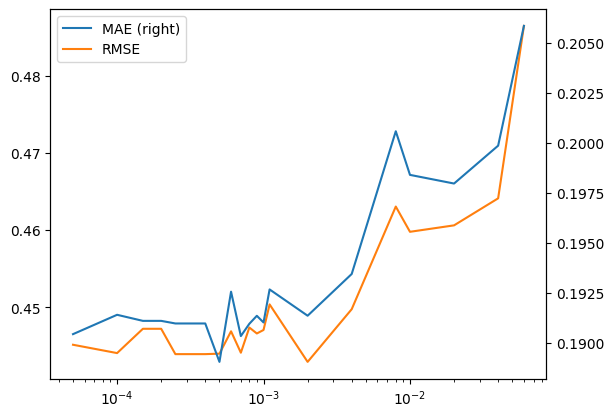

In [20]:
# Backward elimination
results = []
limits = [
    0.00005, 0.0001, 0.00015, 0.0002, 0.00025, 0.0003, 0.00035, 0.0004,
    0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.0011, 0.002, 0.004,
    0.008, 0.01, 0.02, 0.04, 0.06
]
for limit in limits:
    mask = [feature in importance_df[importance_df > limit] for feature in features]
    xgb_reg.fit(
        X=X_train[:, mask],
        y=y_train,
        eval_set=[(X_val[:, mask], y_val)],
        verbose=False
    )
    results.append(
        model_kpi(
            model=xgb_reg,
            X=X_val[:, mask],
            y=y_val
        )
    )
results_df = pd.DataFrame(
    data=results,
    index=limits,
    columns=["MAE", "RMSE"]
)
results_df.plot(
    secondary_y="MAE",
    logx=True,
)

In [21]:
# Run model with best features
limit = 0.007
mask = [feature in importance_df[importance_df > limit] for feature in features]
print(mask)
xgb_reg.fit(
    X=X_train[:, mask],
    y=y_train,
    eval_set=[(X_val[:, mask], y_val)],
    verbose=True
)
y_train_pred = xgb_reg.predict(X_train[:, mask])
y_test_pred = xgb_reg.predict(X_test[:, mask])
kpi_ml(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    name="XGBRegressor with Best Features",
)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True]
[0]	validation_0-mae:214.75330
[1]	validation_0-mae:213.71195
[2]	validation_0-mae:212.67153
[3]	validation_0-mae:211.64389
[4]	validation_0-mae:210.62492
[5]	validation_0-mae:209.60753
[6]	validation_0-mae:208.60051
[7]	validation_0-mae:207.60786
[8]	validation_0-mae:206.61251
[9]	validation_0-mae:205.59493
[10]